In [1]:
import time
import numpy as np
import pandas as pd
import sys
import os
from tqdm.auto import tqdm
import brainpy as bp
import brainpy.math as bm
import traceback

bm.set_platform("cpu")

try:
    parent_dir = os.path.dirname(os.path.abspath(__file__))
except:
    parent_dir = os.path.abspath("..")
print("Parent directory:", parent_dir)

sys.path.append(parent_dir)


from models.network import run_simulation

Parent directory: /Users/mablin/Projects/github.com/mablin7/cerebellum-jax


In [2]:
G_GJ_VALUES = np.linspace(0.0, 0.05, 10)
SEEDS = [42, 123, 99, 7, 2024]
DURATION = 10_000.0
DT = 0.025
BASE_NET_PARAMS = {}

In [21]:
results_subdir = os.path.join(parent_dir, "results", f"io_synchrony_{time.strftime('%m-%d_%H:%M:%S')}")
os.makedirs(results_subdir, exist_ok=True)

In [4]:
results_subdir = os.path.join(parent_dir, "results", f"io_synchrony_{time.strftime('%m-%d_%H:%M:%S')}")
os.makedirs(results_subdir, exist_ok=True)

seed = SEEDS[0]
for g_gj in tqdm([0.0, 0.02, 0.05], position=0, desc="g_gj"):
    current_net_params = BASE_NET_PARAMS.copy()
    current_net_params["IO_g_gj"] = g_gj

    try:
        runner = run_simulation(
            duration=DURATION, dt=DT, net_params=current_net_params, seed=seed
        )
        
        data = {}
        for k in runner.mon:
            data[k] = np.array(runner.mon[k])
        run_path = os.path.join(results_subdir, f"g_gj{g_gj}_seed{seed}.npz")
        np.savez(run_path, **data)

    except Exception as e:
        full_error = traceback.format_exc()
        tqdm.write(f"Error during simulation: {e}\n{full_error}")

g_gj:   0%|          | 0/3 [00:00<?, ?it/s]

W0000 00:00:1743352643.707834 13964813 mps_client.cc:510] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!
I0000 00:00:1743352643.721565 13964813 service.cc:145] XLA service 0x12c40f550 initialized for platform METAL (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1743352643.721582 13964813 service.cc:153]   StreamExecutor device (0): Metal, <undefined>
I0000 00:00:1743352643.726811 13964813 mps_client.cc:406] Using Simple allocator.
I0000 00:00:1743352643.726833 13964813 mps_client.cc:384] XLA backend will use up to 17178099712 bytes on device 0 for SimpleAllocator.


Metal device set to: Apple M3

systemMemory: 24.00 GB
maxCacheSize: 8.00 GB



In [16]:
# Load
from glob import glob
from pathlib import Path

{Path(f).stem: np.load(f) for f in glob(os.path.join(results_subdir, "*.npz"))}
data = {}
for f in glob(os.path.join(results_subdir, "*.npz")):
    npz = np.load(f)
    name = Path(f).stem.split("_seed")[0].lstrip("g_gj")
    data[name] = {}
    for k in npz.keys():
        data[name][k] = npz.get(k)

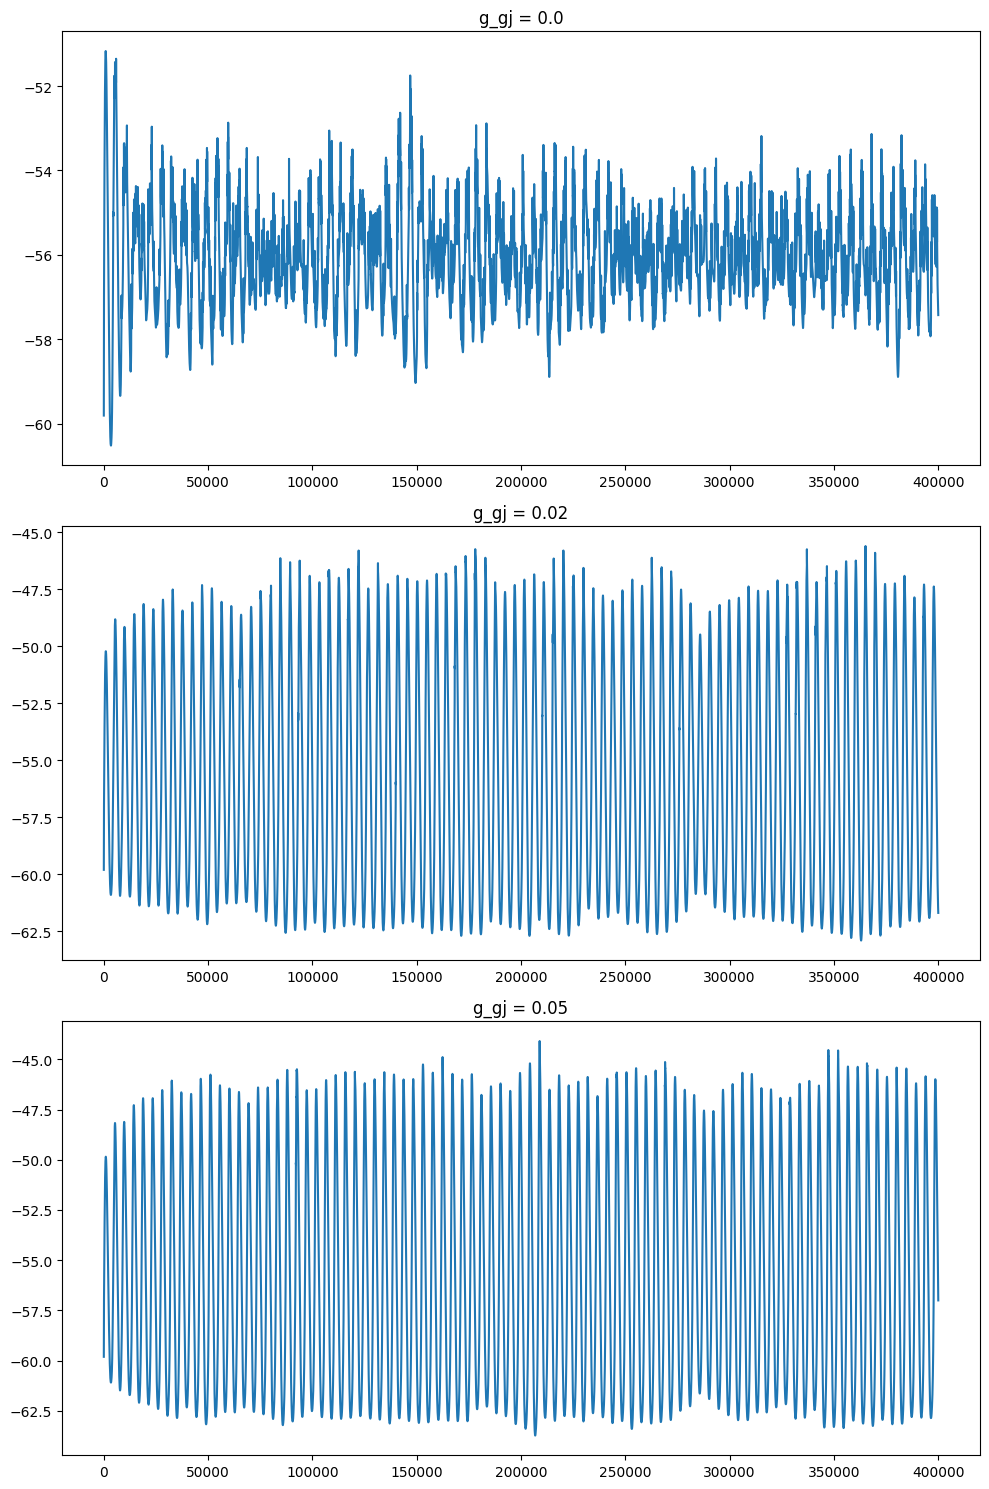

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 15))

plt.subplot(3, 1, 1)
plt.plot(np.mean(data["0.0"]["io.V_soma"], axis=1))
plt.title("g_gj = 0.0")

plt.subplot(3, 1, 2)
plt.plot(np.mean(data["0.02"]["io.V_soma"], axis=1))
plt.title("g_gj = 0.02")

plt.subplot(3, 1, 3)
plt.plot(np.mean(data["0.05"]["io.V_soma"], axis=1))
plt.title("g_gj = 0.05")

plt.tight_layout()
plt.show()


In [21]:
from utils.analysis_utils import (
    calculate_avg_firing_rate,
    calculate_io_sto_synchrony,
    calculate_voltage_std_synchrony,
    calculate_fourier_peak,
    check_network_stability,
)

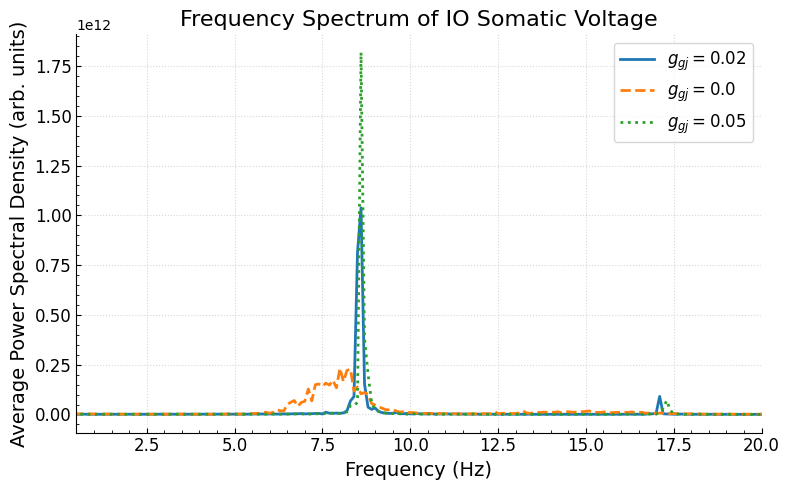

In [28]:

FS_SCALE: float = 1000.0   # Factor to convert dt to sampling frequency

# --- Plotting Parameters ---
FONT_SIZE_LABEL = 14
FONT_SIZE_TITLE = 16
FONT_SIZE_TICKS = 12
FONT_SIZE_LEGEND = 12
LINE_WIDTH = 2.0
FREQ_RANGE_PLOT = (0.5, 20.0) # Frequency range (Hz) to display on the plot

# Define distinct line styles and potentially colors
# Example: colors = plt.cm.viridis(np.linspace(0, 1, len(data))) # Colormap option
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b'] # Default matplotlib colors
linestyles = ['-', '--', ':', '-.']

# Create figure and axes objects for more control
fig, ax = plt.subplots(figsize=(8, 5)) # Adjusted figsize slightly for typical aspect ratio

# --- Plotting Loop ---
style_idx = 0
for i, (g_gj, mon_data) in enumerate(data.items()):
    voltage_traces = mon_data['io.V_soma']
    num_steps, num_neurons = voltage_traces.shape

    fs = FS_SCALE / DT # Sampling frequency

    # Calculate average power spectrum (logic from calculate_fourier_peak)
    total_power_spectrum = np.zeros(num_steps // 2)
    for n_idx in range(num_neurons):
        trace = voltage_traces[:, n_idx]
        trace_detrended = trace - np.mean(trace)
        fft_vals = np.fft.fft(trace_detrended)
        power = np.abs(fft_vals[:num_steps // 2])**2
        total_power_spectrum += power
    avg_power_spectrum = total_power_spectrum / num_neurons
    frequencies = np.fft.fftfreq(num_steps, d=DT / FS_SCALE)[:num_steps // 2]

    # Get style for this line
    color = colors[i % len(colors)]
    linestyle = linestyles[i % len(linestyles)]

    # Plotting on the axes object
    ax.plot(frequencies, avg_power_spectrum,
            label=f'$g_{{gj}} = {g_gj}$', # Use LaTeX for g_gj
            linewidth=LINE_WIDTH,
            color=color,
            linestyle=linestyle)
    style_idx += 1

# --- Formatting the plot ---
ax.set_xlabel("Frequency (Hz)", fontsize=FONT_SIZE_LABEL)
ax.set_ylabel("Average Power Spectral Density (arb. units)", fontsize=FONT_SIZE_LABEL) # Slightly more formal name
ax.set_title("Frequency Spectrum of IO Somatic Voltage", fontsize=FONT_SIZE_TITLE)
ax.set_xlim(FREQ_RANGE_PLOT)

# Improve ticks and spines
ax.tick_params(axis='both', which='major', direction='in', labelsize=FONT_SIZE_TICKS, top=False, right=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Optional: Add minor ticks if desired
from matplotlib.ticker import AutoMinorLocator
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(axis='both', which='minor', direction='in', top=False, right=False)


# Add legend
# ax.legend(fontsize=FONT_SIZE_LEGEND, frameon=False) # frameon=False for no box
ax.legend(fontsize=FONT_SIZE_LEGEND)

ax.grid(True, linestyle=':', alpha=0.5) # Lighter grid style

# Adjust layout
fig.tight_layout()

# --- Display ---
plt.show()

# --- Saving (Example) ---
# To save for publication, use high DPI and appropriate format:
# fig.savefig("io_soma_spectrum.png", dpi=300, bbox_inches='tight')
# fig.savefig("io_soma_spectrum.pdf", bbox_inches='tight') # Vector format

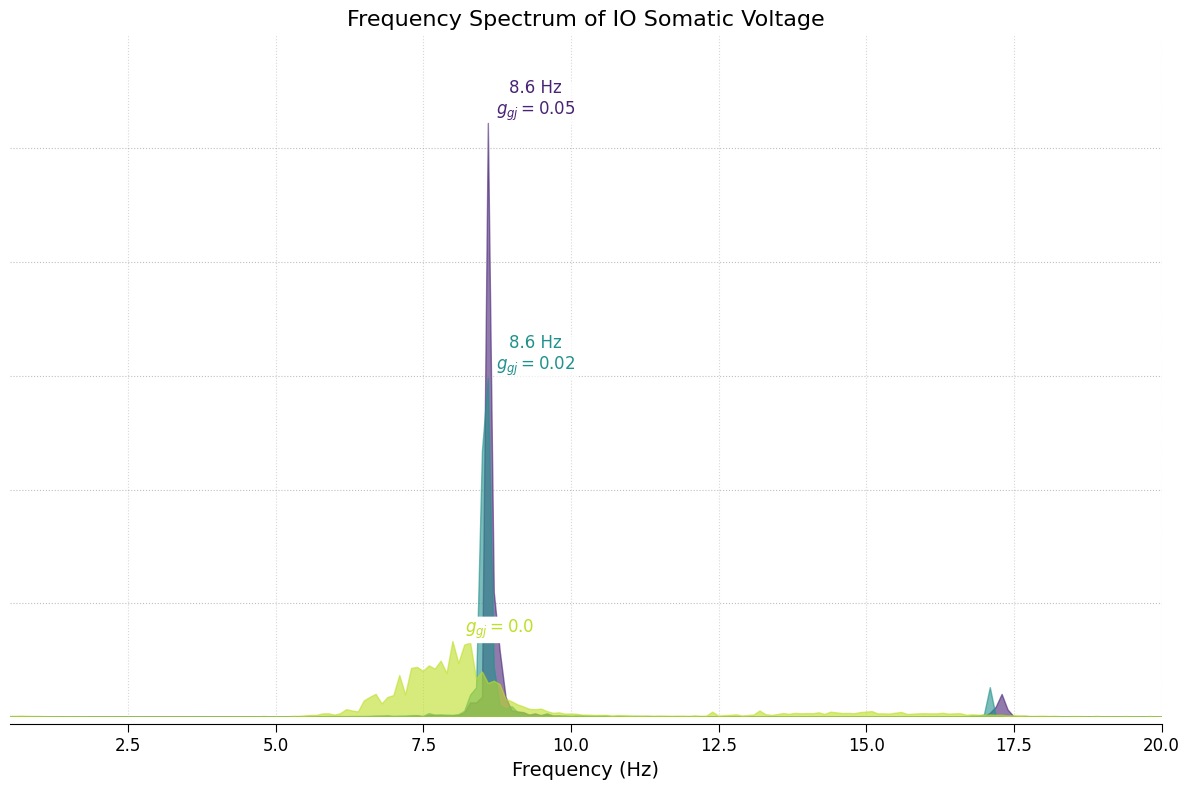

In [47]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

# --- Assumed variables ---
# data: dict = { ggj_val: {'io.V_soma': np.ndarray} for ggj_val in ... }
# DT: float                   # Simulation time step in ms (e.g., 0.025)
# FS_SCALE: float = 1000.0   # Factor to convert dt to sampling frequency

# --- Plotting Parameters ---
FONT_SIZE_LABEL = 14
FONT_SIZE_TITLE = 16
FONT_SIZE_TICKS = 12
FONT_SIZE_ANNOTATE = 12
FREQ_RANGE_PLOT = (0.5, 20.0)
ANNOTATION_OFFSET_Y = 0.05 # Vertical offset for text above peak
ANNOTATION_OFFSET_X_SHIFT = 0.2 # Horizontal shift for close peaks
ALPHA_FILL = 0.6 # Transparency for filled areas

# --- Prepare Data ---
sorted_ggj = sorted(data.keys())
num_plots = len(sorted_ggj)
colors = cm.viridis(np.linspace(0.9, 0.1, num_plots)) # Use a perceptually uniform map

# --- Plotting Setup ---
fig, ax = plt.subplots(figsize=(12, 8))
spectra_data = {}
max_psd_overall = 0

for g_gj in sorted_ggj:
    mon_data = data[g_gj]
    if 'io.V_soma' not in mon_data: continue
    voltage_traces = mon_data['io.V_soma']
    if hasattr(voltage_traces, 'to_numpy'): voltage_traces = voltage_traces.to_numpy()
    num_steps, num_neurons = voltage_traces.shape
    if num_neurons == 0: continue

    fs = FS_SCALE / DT
    total_power_spectrum = np.zeros(num_steps // 2)
    for n_idx in range(num_neurons):
        trace = voltage_traces[:, n_idx]
        trace_detrended = trace - np.mean(trace)
        fft_vals = np.fft.fft(trace_detrended)
        power = np.abs(fft_vals[:num_steps // 2])**2
        total_power_spectrum += power
    avg_power_spectrum = total_power_spectrum / num_neurons
    frequencies = np.fft.fftfreq(num_steps, d=DT / FS_SCALE)[:num_steps // 2]

    spectra_data[g_gj] = {'freq': frequencies, 'psd': avg_power_spectrum}
    plot_indices = np.where((frequencies >= FREQ_RANGE_PLOT[0]) & (frequencies <= FREQ_RANGE_PLOT[1]))[0]
    if len(plot_indices) > 0:
        max_psd_overall = max(max_psd_overall, np.max(avg_power_spectrum[plot_indices]))


# --- Plotting Loop ---
peak_annotations = []

for i, g_gj in enumerate(sorted_ggj):
    if g_gj not in spectra_data: continue

    frequencies = spectra_data[g_gj]['freq']
    avg_power_spectrum = spectra_data[g_gj]['psd']

    # Scale PSD relative to overall max for consistent visual height if needed
    # If max_psd_overall > 1e-9:
    #     scaled_psd = avg_power_spectrum / max_psd_overall
    # else:
    #     scaled_psd = avg_power_spectrum
    scaled_psd = avg_power_spectrum # Try without scaling first

    # Plot filled area, overlapping
    ax.fill_between(frequencies, 0, scaled_psd,
                    color=colors[i], alpha=ALPHA_FILL, zorder=num_plots - i, # Higher g_gj on top
                    label=f'$g_{{gj}} = {g_gj}$') # Label for potential future legend use


    idx_range = np.where((frequencies >= FREQ_RANGE_PLOT[0]) & (frequencies <= FREQ_RANGE_PLOT[1]))[0]
    if len(idx_range) > 0:
        peak_idx_local = np.argmax(scaled_psd[idx_range])
        peak_idx_global = idx_range[peak_idx_local]
        peak_freq = frequencies[peak_idx_global]
        peak_val = scaled_psd[peak_idx_global]
        peak_annotations.append({'freq': peak_freq, 'val': peak_val, 'ggj': g_gj, 'color': colors[i]})


# --- Formatting the plot ---
ax.set_xlabel("Frequency (Hz)", fontsize=FONT_SIZE_LABEL)
ax.set_title("Frequency Spectrum of IO Somatic Voltage", fontsize=FONT_SIZE_TITLE)
ax.set_xlim(FREQ_RANGE_PLOT)

ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_position(('outward', 5)) # Keep bottom spine slightly outward
ax.set_yticks([])
ax.set_ylabel('')

ax.tick_params(axis='x', which='major', direction='out', labelsize=FONT_SIZE_TICKS, length=6)

# Add grid
ax.grid(True, axis='both', linestyle=':', alpha=0.5, zorder=0)  # Add horizontal grid lines with low zorder to stay behind data


# --- Add Peak Annotations (with basic overlap avoidance) ---
peak_annotations.sort(key=lambda x: x['freq']) # Sort by frequency
last_annotated_freq = -np.inf
current_offset_factor = 0

max_y_val_annotated = 0
for peak_info in peak_annotations:
    annotation_x = peak_info['freq']
    annotation_y = peak_info['val'] + ANNOTATION_OFFSET_Y
    

    # Simple horizontal shift if peaks are too close
    if annotation_x - last_annotated_freq < ANNOTATION_OFFSET_X_SHIFT * 2:
         current_offset_factor += 0.6 # Increment vertical offset for next close peak
         annotation_y += current_offset_factor * ANNOTATION_OFFSET_Y # Add extra vertical offset
         # annotation_x += ANNOTATION_OFFSET_X_SHIFT # Optional horizontal shift too
    else:
         current_offset_factor = 0 # Reset offset factor if peaks are far apart
         last_annotated_freq = annotation_x


    # add extra x offset to avoid overlap with plot
    annotation_x += 0.8
    if peak_info['ggj'] != "0.0":
        ax.text(annotation_x, annotation_y, f'{peak_info["freq"]:.1f} Hz\n$g_{{gj}}={peak_info["ggj"]}$',
                ha='center', va='bottom', fontsize=FONT_SIZE_ANNOTATE, color=peak_info['color'],
                bbox=dict(boxstyle='round,pad=0.1', fc='white', ec='none', alpha=0.7))
    else:
        ax.text(annotation_x, annotation_y, f'$g_{{gj}}={peak_info["ggj"]}$',
                ha='center', va='bottom', fontsize=FONT_SIZE_ANNOTATE, color=peak_info['color'],
                bbox=dict(boxstyle='round,pad=0.1', fc='white', ec='none'))

    max_y_val_annotated = max(max_y_val_annotated, annotation_y)


ax.set_ylim(0, max_y_val_annotated * 1.15) # Adjust ylim to fit annotations

num_grid_lines = 5 # Choose how many grid lines you want
plot_ymin, plot_ymax = ax.get_ylim()
# Generate positions for the grid lines within the y-limits
yticks_for_grid = np.linspace(plot_ymin, plot_ymax, num_grid_lines + 2)[1:-1] # Exclude top/bottom edges

# 2. Set ticks for grid generation
ax.set_yticks(yticks_for_grid)

# 3. Draw the grid using the specified ticks
ax.yaxis.grid(True, linestyle=':', alpha=0.5, color='grey', zorder=0) # Draw grid behind plots

# 4. Hide the tick labels
ax.set_yticklabels([])

# 5. Optional: Hide the tick marks themselves
ax.tick_params(axis='y', which='both', length=0)

fig.tight_layout()
plt.show()


In [54]:
for k, run in data.items():
    print(k)
    # io_voltage = run["io.V_soma"]
    # avg_kuramoto = np.mean(
    #     calculate_io_sto_synchrony(
    #         io_voltage, DT, lowcut=7.5, highcut=10.0
    #     )
    # )
    # print(avg_kuramoto)
    # avg_std_sync = np.mean(calculate_voltage_std_synchrony(io_voltage))
    # peak_freq, _, _ = calculate_fourier_peak(
    #     io_voltage, DT, freq_range=(7.5, 10.0)
    # )
    # print(peak_freq)
    # print()
    pc_rate = calculate_avg_firing_rate(run["pc.spike"], DT, DURATION)
    print(pc_rate)
    cn_rate = calculate_avg_firing_rate(run["cn.spike"], DT, DURATION)
    print(cn_rate)
    # IO rate calculation from stability check logic
    io_thresh =-30.0
    io_v_soma_np = run["io.V_soma"]
    io_spikes = (io_v_soma_np[1:] > io_thresh) & (
        io_v_soma_np[:-1] <= io_thresh
    )
    io_spikes_full = np.vstack(
        [np.zeros((1, io_spikes.shape[1]), dtype=bool), io_spikes]
    )
    io_rate = calculate_avg_firing_rate(io_spikes_full, DT, DURATION)
    print(io_rate)
    print()

0.02
86.077
33.4875
0.165625

0.0
83.19500000000001
35.455
1.5421875

0.05
86.313
33.3375
0.0671875



Analyzing CS and SS Pause Synchrony...


/var/folders/xd/wcxw_5hn6rz2brc42jwv7f7r0000gn/T/ipykernel_80624/3761415726.py:171: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(pad=0.5, h_pad=1.0)


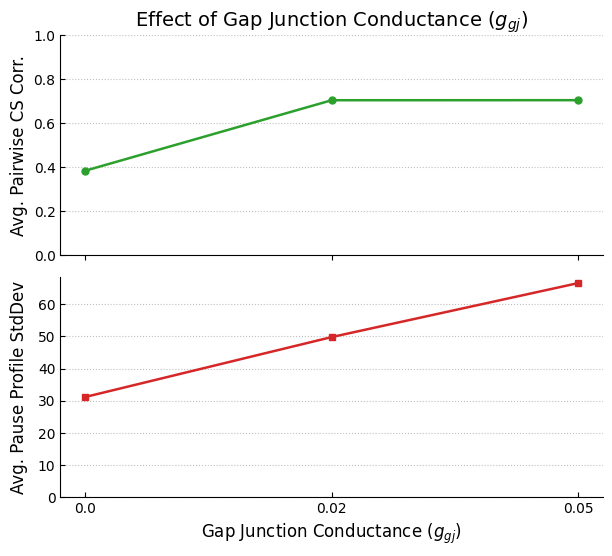

In [63]:
# === Analyze and Plot CS / SS Pause Synchrony ===

# --- Hardcoded Parameters (Defaults from network.py) ---
IOPC_IO_THRESHOLD = -30.0
IOPC_DELAY_MS = 15.0
NUM_PC = 100
NUM_IO = 64 # Default number of IO neurons
# IMPORTANT: Hardcoded IO->PC Connectivity Assumption (replace if possible)
# This assumes PC `i` receives input from IO `i % NUM_IO`.
# Load actual connectivity if available for accurate results.
io_source_for_pc = np.arange(NUM_PC) % NUM_IO

# --- Assumed variables from notebook ---
# data: dict = { ggj_val: mon_data for ggj_val in ... } # Dict containing monitor data
# DT: float                   # Simulation time step in ms (e.g., 0.025)

# --- Analysis Parameters ---
CS_EVENT_KEY_ALT = 'io.V_soma'        # Monitor key for IO voltage
SS_SPIKE_KEY = 'pc.spike'             # Monitor key for simple spikes
SS_PAUSE_WINDOW_MS = (-20, 100)       # Time window around CS for pause analysis (ms)
SS_RATE_BIN_MS = 5.0                  # Bin size for calculating instantaneous rate (ms)

# --- Plotting Parameters ---
FONT_SIZE_LABEL = 12
FONT_SIZE_TITLE = 14
FONT_SIZE_TICKS = 10
MARKER_SIZE = 5
LINE_WIDTH = 1.8
CAP_SIZE = 3
POINT_ALPHA = 0.4 # Keep for potential future use if plotting individual seeds
POINT_SIZE = 15

# --- Data Aggregation ---
analysis_results = []
G_GJ_VALUES_FOUND = sorted(list(data.keys())) # Get g_gj values present in data

print("Analyzing CS and SS Pause Synchrony...")
for g_gj in G_GJ_VALUES_FOUND:
    mon_data = data[g_gj]

    # Check required data exists
    if CS_EVENT_KEY_ALT not in mon_data or SS_SPIKE_KEY not in mon_data:
        print(f"Warning: Missing required data ('{CS_EVENT_KEY_ALT}' or '{SS_SPIKE_KEY}') for g_gj={g_gj}. Skipping.")
        analysis_results.append({'g_gj': g_gj, 'avg_cs_corr': np.nan, 'avg_pause_profile_std': np.nan})
        continue

    io_v_soma = mon_data[CS_EVENT_KEY_ALT]
    ss_spikes = mon_data[SS_SPIKE_KEY]
    if hasattr(io_v_soma, 'to_numpy'): io_v_soma = io_v_soma.to_numpy()
    if hasattr(ss_spikes, 'to_numpy'): ss_spikes = ss_spikes.to_numpy()

    num_steps, num_io_actual = io_v_soma.shape
    num_steps_ss, num_pc_actual = ss_spikes.shape

    if num_io_actual != NUM_IO or num_pc_actual != NUM_PC:
        print(f"Warning: Mismatch in neuron numbers for g_gj={g_gj}. Expected IO={NUM_IO}, PC={NUM_PC}. Found IO={num_io_actual}, PC={num_pc_actual}.")
        # Attempt to continue if dimensions allow, otherwise skip
        if num_pc_actual != NUM_PC:
           print("Skipping analysis for this g_gj due to PC number mismatch.")
           analysis_results.append({'g_gj': g_gj, 'avg_cs_corr': np.nan, 'avg_pause_profile_std': np.nan})
           continue
        # Adjust connectivity assumption if IO number differs, though this is risky
        # io_source_for_pc = np.arange(num_pc_actual) % num_io_actual


    # --- Reconstruct CS Events at PC ---
    delay_steps = int(round(IOPC_DELAY_MS / DT))
    io_spiked = (io_v_soma[1:] > IOPC_IO_THRESHOLD) & (io_v_soma[:-1] <= IOPC_IO_THRESHOLD)
    io_spiked_full = np.vstack([np.zeros((1, num_io_actual), dtype=bool), io_spiked])
    pc_cs_events = np.zeros((num_steps, num_pc_actual), dtype=bool)

    for pc_idx in range(num_pc_actual):
        source_io_idx = io_source_for_pc[pc_idx]
        if source_io_idx >= num_io_actual: continue # Skip if assumed IO index is out of bounds

        io_spike_steps = np.where(io_spiked_full[:, source_io_idx])[0]
        cs_arrival_steps = io_spike_steps + delay_steps
        valid_arrivals = cs_arrival_steps[cs_arrival_steps < num_steps]
        if len(valid_arrivals) > 0:
            pc_cs_events[valid_arrivals, pc_idx] = True

    # --- CS Synchrony Calculation ---
    avg_cs_corr = np.nan
    if pc_cs_events.shape[1] >= 2:
        correlations = []
        num_neurons = pc_cs_events.shape[1]
        for i in range(num_neurons):
            for j in range(i + 1, num_neurons):
                series_i = pc_cs_events[:, i].astype(float)
                series_j = pc_cs_events[:, j].astype(float)
                std_i = np.std(series_i)
                std_j = np.std(series_j)
                if std_i > 1e-9 and std_j > 1e-9:
                    corr_matrix = np.corrcoef(series_i, series_j)
                    correlations.append(corr_matrix[0, 1])
                elif std_i < 1e-9 and std_j < 1e-9: correlations.append(1.0)
                else: correlations.append(0.0)
        if correlations: avg_cs_corr = np.mean(correlations)

    # --- SS Pause Synchrony Calculation ---
    avg_pause_profile_std = np.nan
    win_start_idx = int(round(SS_PAUSE_WINDOW_MS[0] / DT))
    win_end_idx = int(round(SS_PAUSE_WINDOW_MS[1] / DT))
    win_len_idx = win_end_idx - win_start_idx
    bin_steps = max(1, int(round(SS_RATE_BIN_MS / DT)))
    num_rate_bins = win_len_idx // bin_steps

    if win_len_idx > 0 and num_rate_bins > 0:
        all_avg_profiles = []
        for pc_idx in range(num_pc_actual):
            pc_cs_indices = np.where(pc_cs_events[:, pc_idx])[0]
            pc_ss_spikes = ss_spikes[:, pc_idx]
            pc_event_profiles = []

            for cs_idx in pc_cs_indices:
                start = cs_idx + win_start_idx
                end = cs_idx + win_end_idx
                if start >= 0 and end < num_steps:
                    ss_window = pc_ss_spikes[start:end]
                    binned_spikes = ss_window[:num_rate_bins*bin_steps].reshape(num_rate_bins, bin_steps).sum(axis=1)
                    rate_profile_hz = binned_spikes / (bin_steps * DT / 1000.0)
                    pc_event_profiles.append(rate_profile_hz)

            if pc_event_profiles:
                 avg_profile = np.mean(np.array(pc_event_profiles), axis=0)
                 all_avg_profiles.append(avg_profile)

        if len(all_avg_profiles) >= 2:
            profiles_array = np.array(all_avg_profiles)
            std_dev_over_time = np.std(profiles_array, axis=0)
            pause_start_bin = abs(win_start_idx) // bin_steps
            avg_pause_profile_std = np.mean(std_dev_over_time[pause_start_bin:])

    # Store results
    analysis_results.append({
        'g_gj': g_gj,
        'avg_cs_corr': avg_cs_corr,
        'avg_pause_profile_std': avg_pause_profile_std
    })

# --- Process Results ---
summary_df_cs = pd.DataFrame(analysis_results).set_index('g_gj')

# --- Create Figure and Axes ---
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(7, 6), sharex=True, gridspec_kw={'hspace': 0.1})

# --- Plot 1: CS Synchrony ---
ax1.plot(summary_df_cs.index, summary_df_cs['avg_cs_corr'], '-o', markersize=MARKER_SIZE, linewidth=LINE_WIDTH, color='#2ca02c', zorder=2)
ax1.set_ylabel('Avg. Pairwise CS Corr.', fontsize=FONT_SIZE_LABEL)
ax1.set_ylim(bottom=min(0, ax1.get_ylim()[0] if not summary_df_cs['avg_cs_corr'].isnull().all() else 0),
             top=max(1.0, ax1.get_ylim()[1] if not summary_df_cs['avg_cs_corr'].isnull().all() else 1.0))
ax1.set_title('Effect of Gap Junction Conductance ($g_{gj}$)', fontsize=FONT_SIZE_TITLE)
ax1.tick_params(axis='y', which='major', direction='in', labelsize=FONT_SIZE_TICKS, right=False)
ax1.spines['right'].set_visible(False); ax1.spines['top'].set_visible(False)
ax1.grid(True, axis='y', linestyle=':', alpha=0.5, color='grey')

# --- Plot 2: SS Pause Synchrony ---
ax2.plot(summary_df_cs.index, summary_df_cs['avg_pause_profile_std'], '-s', markersize=MARKER_SIZE, linewidth=LINE_WIDTH, color='#d62728', zorder=2)
ax2.set_ylabel('Avg. Pause Profile StdDev', fontsize=FONT_SIZE_LABEL)
ax2.set_ylim(bottom=0)
ax2.tick_params(axis='y', which='major', direction='in', labelsize=FONT_SIZE_TICKS, right=False)
ax2.spines['right'].set_visible(False); ax2.spines['top'].set_visible(False)
ax2.grid(True, axis='y', linestyle=':', alpha=0.5, color='grey')

# --- Shared X-axis Formatting ---
ax2.set_xlabel('Gap Junction Conductance ($g_{gj}$)', fontsize=FONT_SIZE_LABEL)
ax2.tick_params(axis='x', which='major', direction='in', labelsize=FONT_SIZE_TICKS, top=False)

# --- Layout and Show ---
fig.align_ylabels((ax1, ax2))
fig.tight_layout(pad=0.5, h_pad=1.0)
plt.show()

**Hypothesis:**

We hypothesize that the electrical coupling mediated by gap junctions within the Inferior Olive (IO) network serves to synchronize the firing of IO neurons, leading to temporally coordinated Complex Spike (CS) events in the downstream Purkinje Cell (PC) population. Consequently, the characteristic pauses in Simple Spike (SS) firing that follow CS events are also expected to become more synchronized across PCs as the strength of IO coupling increases. Therefore, manipulating the gap junction conductance (\(g_{gj}\)) should directly modulate the degree of synchrony observed in both CS arrivals and subsequent SS pauses at the PC level.

**Interpretation Guide for the Plot:**

The generated figure presents two key metrics as a function of the IO gap junction conductance, \(g_{gj}\). The top panel illustrates the average pairwise correlation of detected Complex Spike events across the Purkinje Cell population. An ascending trend in this panel, indicating higher correlation values with increasing \(g_{gj}\), would support the hypothesis that stronger IO coupling enhances the temporal coordination of CS delivery to the PCs.

The bottom panel displays the average standard deviation of the Simple Spike firing rate profile during the post-CS pause window, calculated across the PC population. In this representation, a lower standard deviation signifies greater similarity and temporal alignment of the SS pauses among different PCs. Therefore, a descending trend in this panel, showing decreasing standard deviation as \(g_{gj}\) increases, would corroborate the hypothesis by demonstrating that synchronized CS events indeed lead to more synchronized SS pauses.

Concurrent observation of increasing CS correlation (top panel) and decreasing SS pause profile standard deviation (bottom panel) with rising \(g_{gj}\) would provide strong evidence for the significant role of IO gap junctions in structuring the precise temporal dynamics of olivocerebellar communication via coordinated complex spike activity. Conversely, flat or opposing trends might suggest that, within this specific model configuration or parameter regime, the influence of gap junctions on these particular downstream temporal patterns is less pronounced or potentially counteracted by other network interactions.
